In [42]:

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

Setting size of images

In [43]:
in_width = 256
in_height = 256

Loading the image paths

In [44]:
image_filenames_train = []

mask_files = glob('/downloads/Dataset_BUSI_with_GT/malignant/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask',''))

print(image_filenames_train[:10])  
len(image_filenames_train)

['/downloads/Dataset_BUSI_with_GT/malignant\\malignant (1).png', '/downloads/Dataset_BUSI_with_GT/malignant\\malignant (10).png', '/downloads/Dataset_BUSI_with_GT/malignant\\malignant (100).png', '/downloads/Dataset_BUSI_with_GT/malignant\\malignant (101).png', '/downloads/Dataset_BUSI_with_GT/malignant\\malignant (102).png', '/downloads/Dataset_BUSI_with_GT/malignant\\malignant (103).png', '/downloads/Dataset_BUSI_with_GT/malignant\\malignant (104).png', '/downloads/Dataset_BUSI_with_GT/malignant\\malignant (105).png', '/downloads/Dataset_BUSI_with_GT/malignant\\malignant (106).png', '/downloads/Dataset_BUSI_with_GT/malignant\\malignant (107).png']


211

Plotting few images and masks

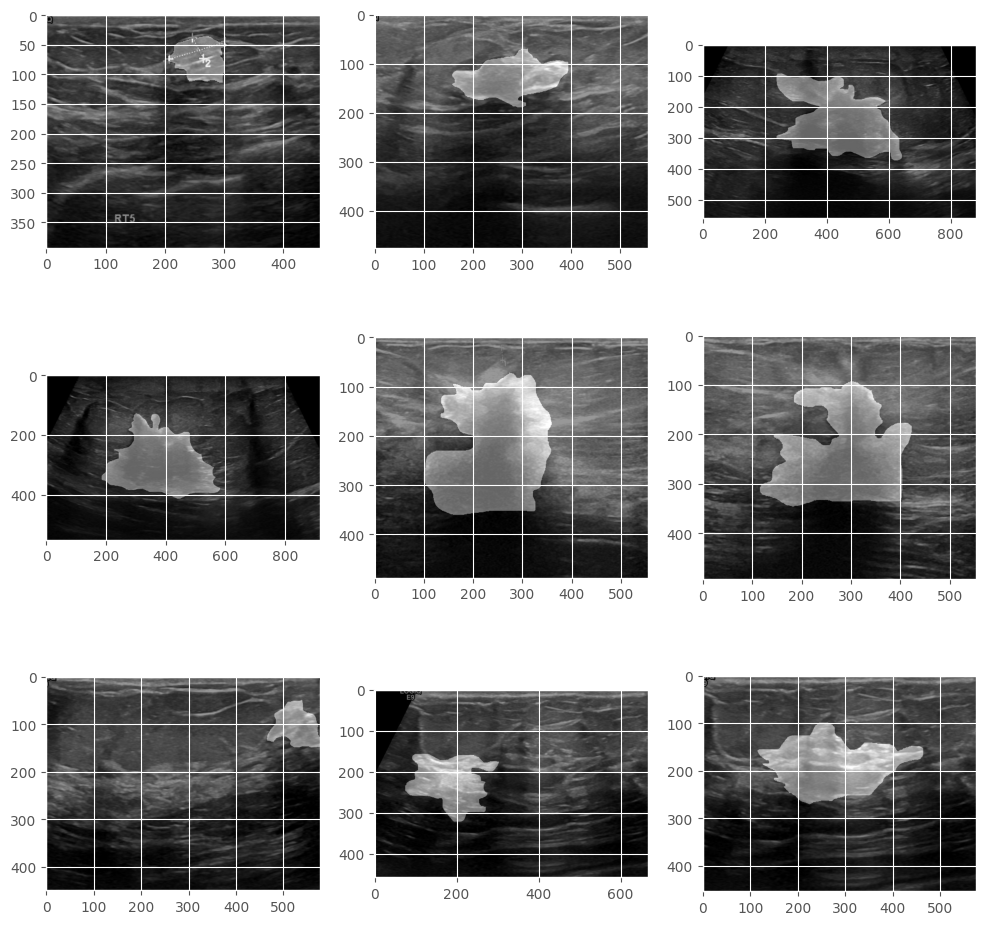

In [45]:
plot_from_img_path(3,3,image_filenames_train,mask_files)

create data frames and split data on train set,validation set and test set

In [46]:
df = pd.DataFrame(data={'image_filenames_train':image_filenames_train,'mask':mask_files})

df_train,df_test = train_test_split(df,test_size=0.1)
#Further split this val and train

df_train,df_val = train_test_split(df_train,test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(151, 2)
(22, 2)
(38, 2)


Data generator, data augmentation and adjust data

In [47]:
#Referring from https://github.com/zhixuhao/unet/blob/master/data.py

def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
   
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [48]:
EPOCHS = 1
BATCH_SIZE = 16
learning_rate = 1e-4
smooth=100

In [49]:
from tensorflow.keras.optimizers.legacy import Adam
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(in_height, in_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(in_height, in_width))
    
model = unet(input_size=(in_height, in_width, 3))


decay_rate = learning_rate / EPOCHS
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=optimizer, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])
callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]
history = model.fit(train_gen,
                    steps_per_epoch=int(len(df_train) / BATCH_SIZE), 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data=test_gen,
                    validation_steps=int(len(df_val) / BATCH_SIZE))

# history = model.fit(train_gen,
#                     steps_per_epoch=len(df_train) / BATCH_SIZE, 
#                     epochs=EPOCHS, 
#                     callbacks=callbacks,
#                     validation_data = test_gen,
#                     validation_steps=len(df_val) / BATCH_SIZE)


Found 150 validated image filenames.
Found 151 validated image filenames.


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image_filenames_train". These filename(s) will be ignored.
  warnings.warn(


9/9 [==============================] - ETA: 0s - loss: -0.2758 - binary_accuracy: 0.4922 - iou: 0.1608 - dice_coefficients: 0.2758  Found 38 validated image filenames.
Found 38 validated image filenames.

Epoch 1: val_loss improved from inf to -0.20586, saving model to unet.hdf5


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 635s 69s/step - loss: -0.2758 - binary_accuracy: 0.4922 - iou: 0.1608 - dice_coefficients: 0.2758 - val_loss: -0.2059 - val_binary_accuracy: 0.1485 - val_iou: 0.1149 - val_dice_coefficients: 0.2059


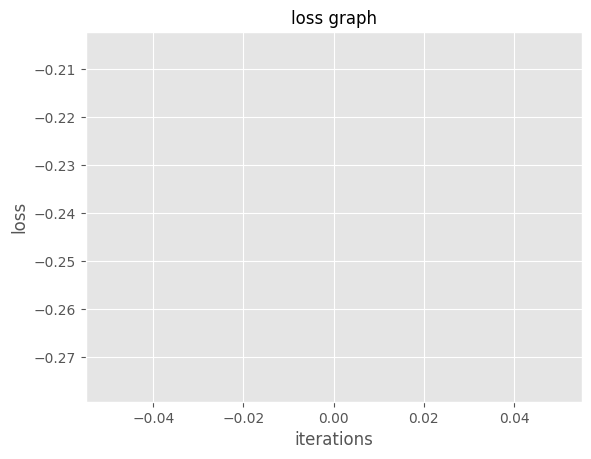

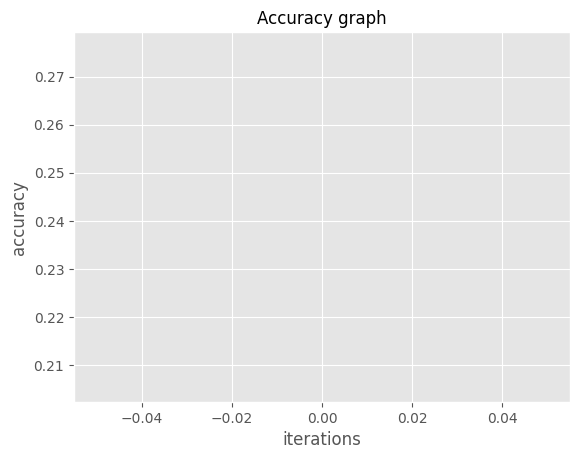

In [50]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

Load previously trained model

In [51]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients':
                                                dice_coefficients})

In [52]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(in_height, in_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

Found 22 validated image filenames.
Found 22 validated image filenames.


1/1 [==============================] - 19s 13s/step - loss: -0.2101 - binary_accuracy: 0.1589 - iou: 0.1166 - dice_coefficients: 0.2087         
Test Loss  -0.21011509001255035
Test IoU  0.1588696539402008
Test Dice Coefficient  0.11663495749235153


Plotting the predicted masks segmentation results from the test image set

1/1 [==============================] - 1s 1s/step


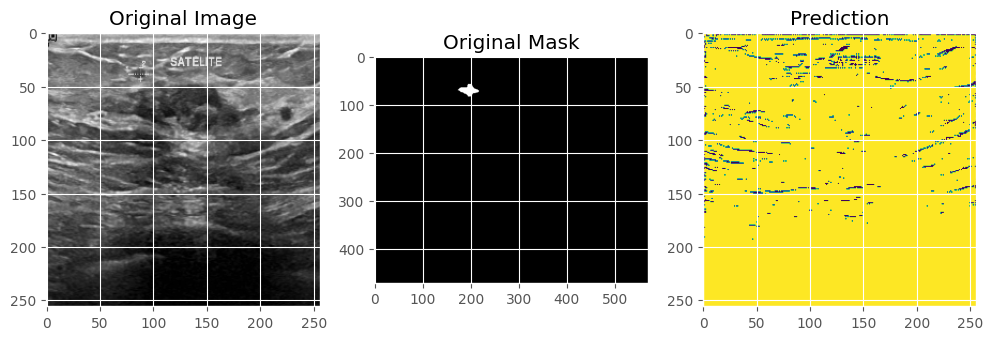

1/1 [==============================] - 1s 883ms/step


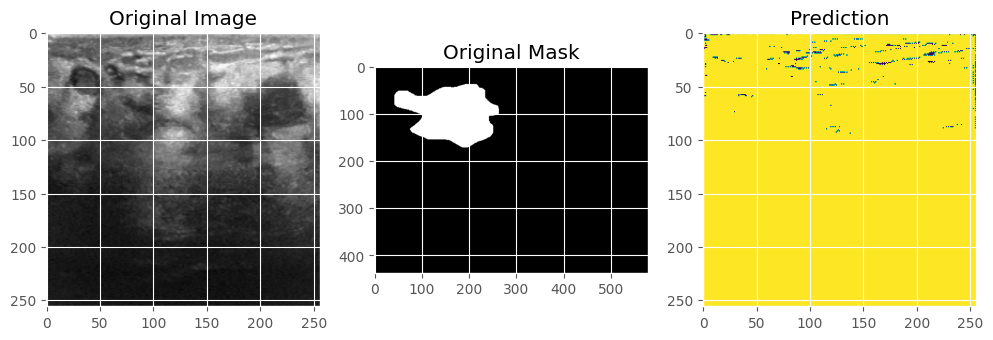

1/1 [==============================] - 1s 1s/step


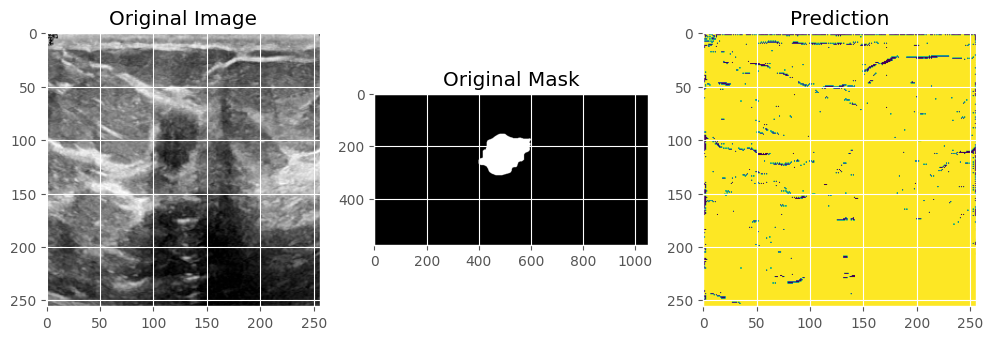

1/1 [==============================] - 1s 1s/step


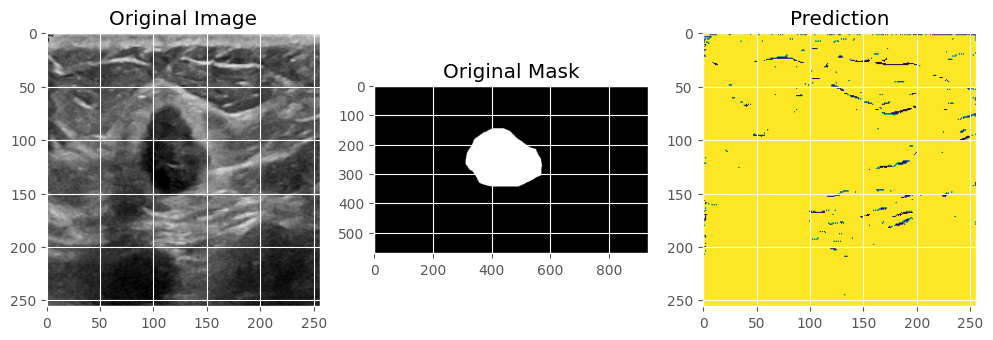

1/1 [==============================] - 1s 861ms/step


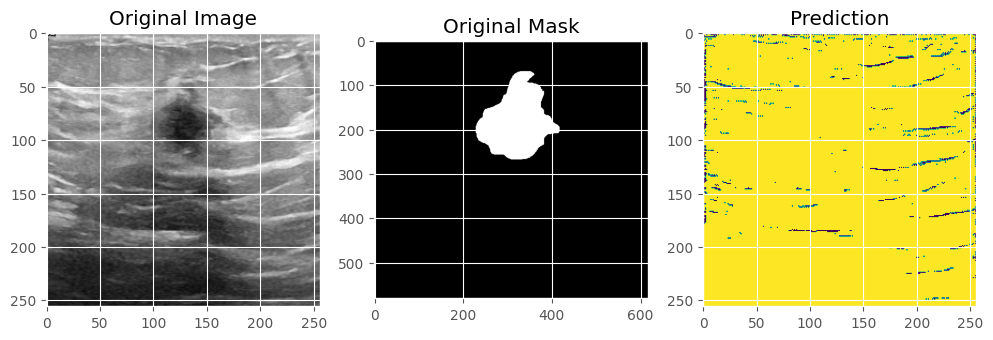

1/1 [==============================] - 1s 861ms/step


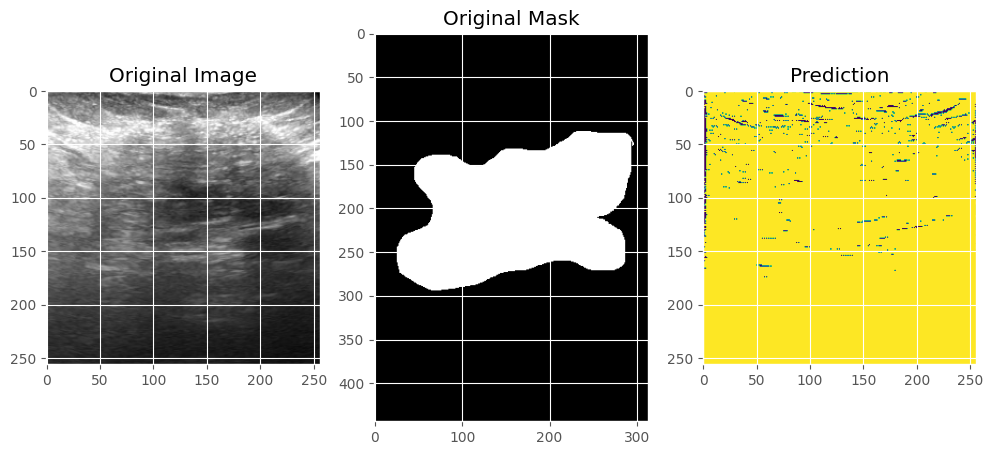

1/1 [==============================] - 1s 1s/step


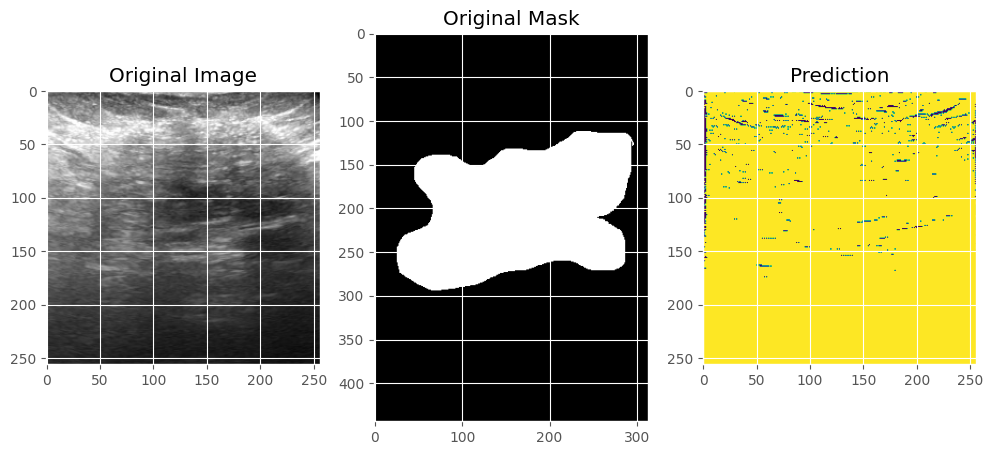

1/1 [==============================] - 1s 980ms/step


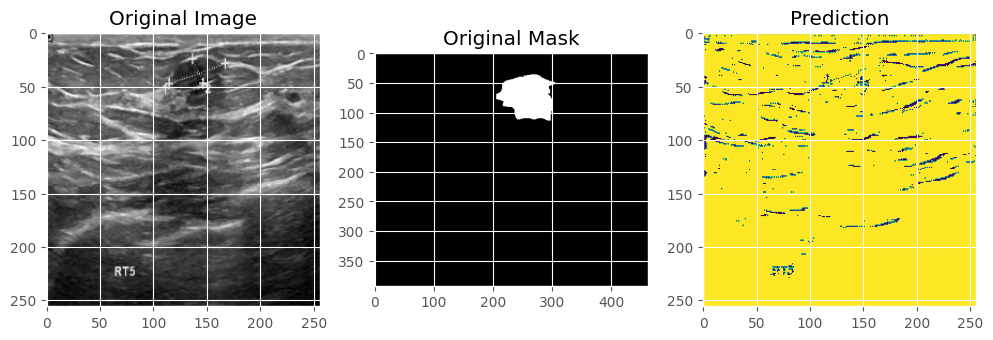

1/1 [==============================] - 1s 1s/step


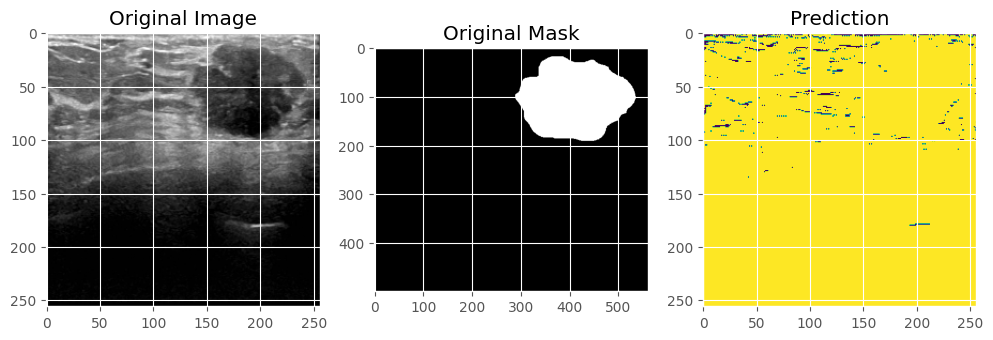

1/1 [==============================] - 1s 935ms/step


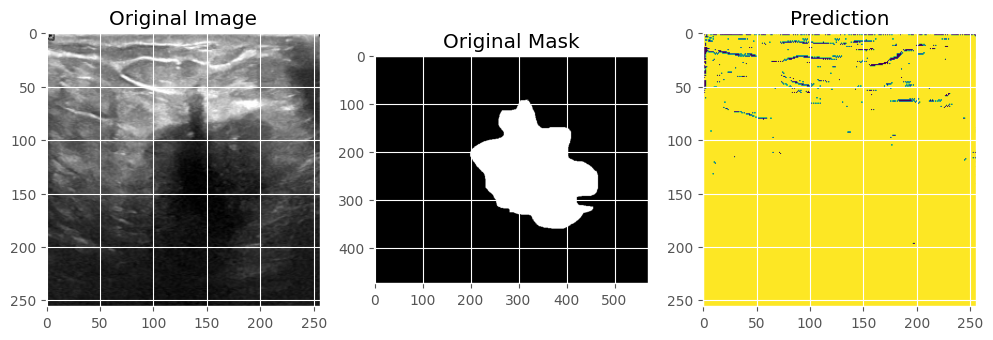

1/1 [==============================] - 1s 868ms/step


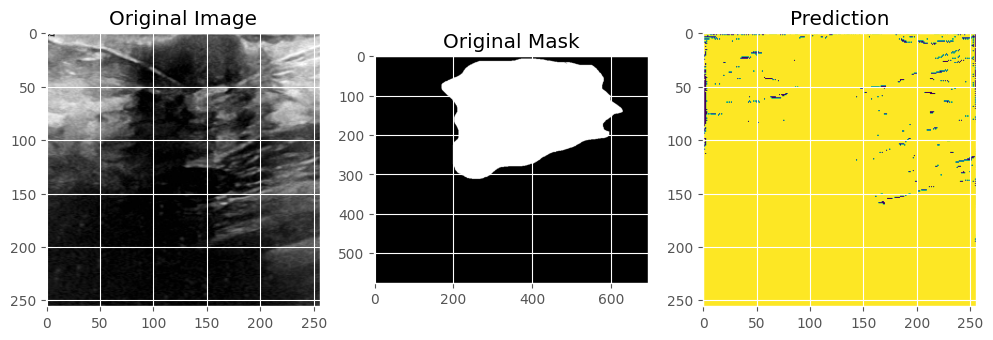

1/1 [==============================] - 1s 872ms/step


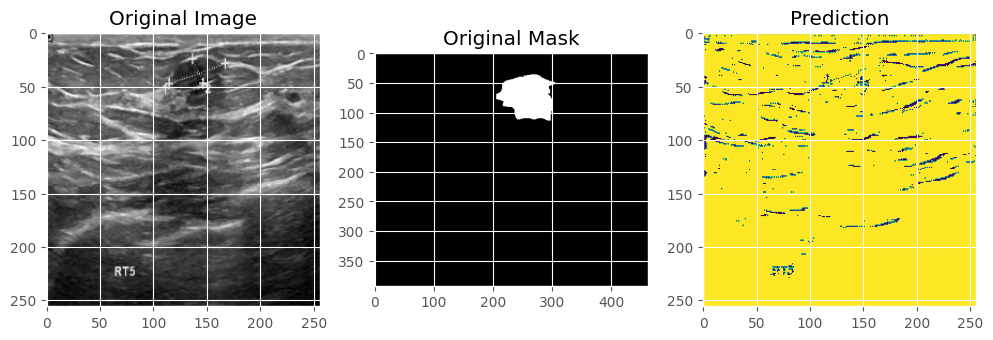

1/1 [==============================] - 1s 911ms/step


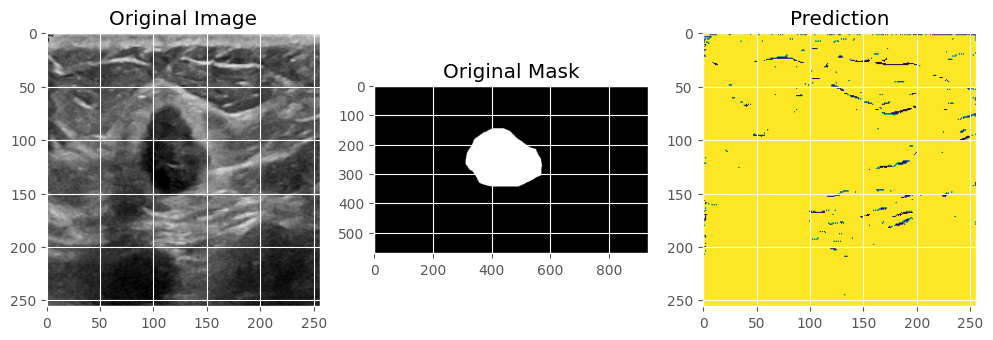

1/1 [==============================] - 1s 1s/step


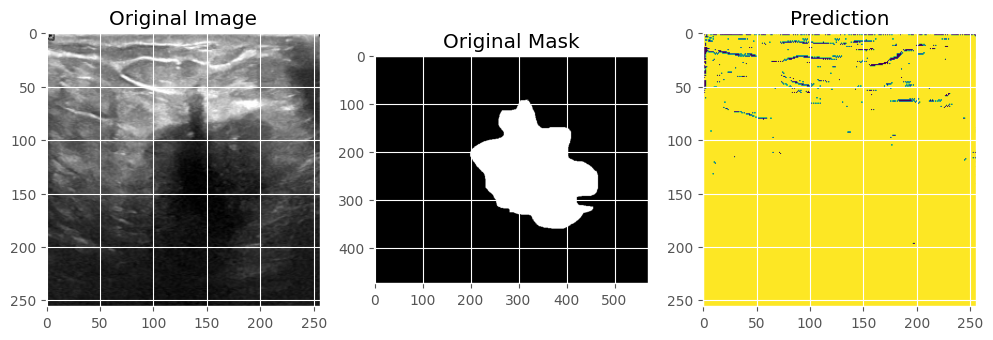

1/1 [==============================] - 1s 1s/step


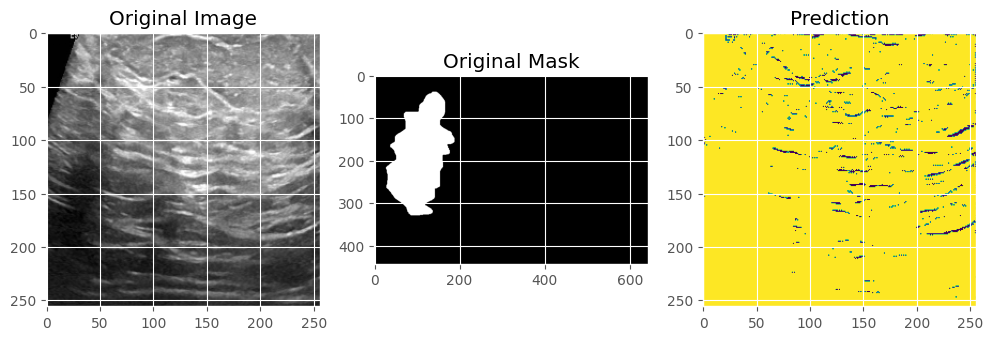

1/1 [==============================] - 1s 887ms/step


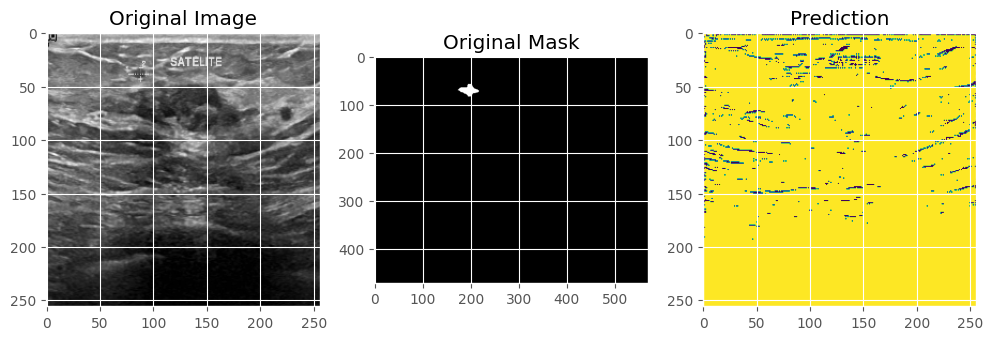

1/1 [==============================] - 1s 974ms/step


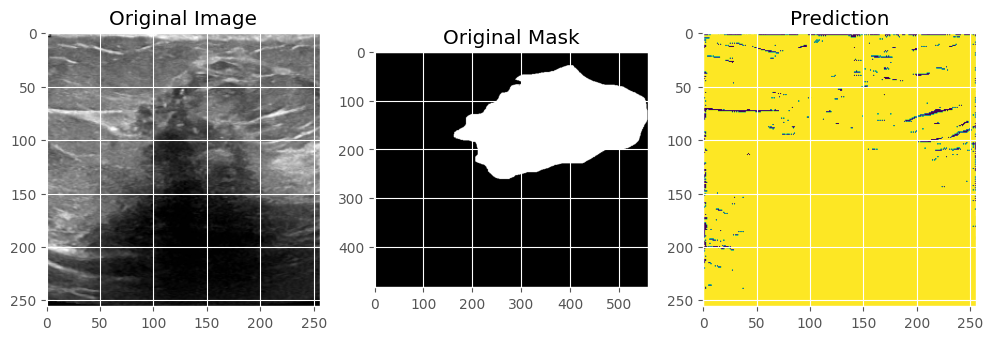

1/1 [==============================] - 1s 929ms/step


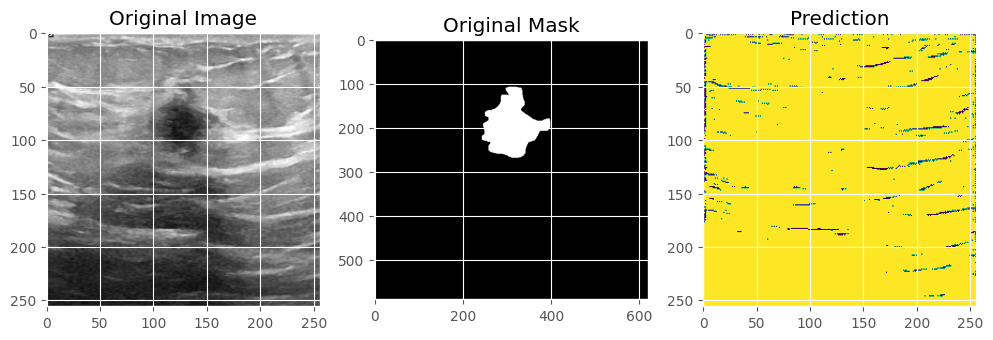

1/1 [==============================] - 1s 887ms/step


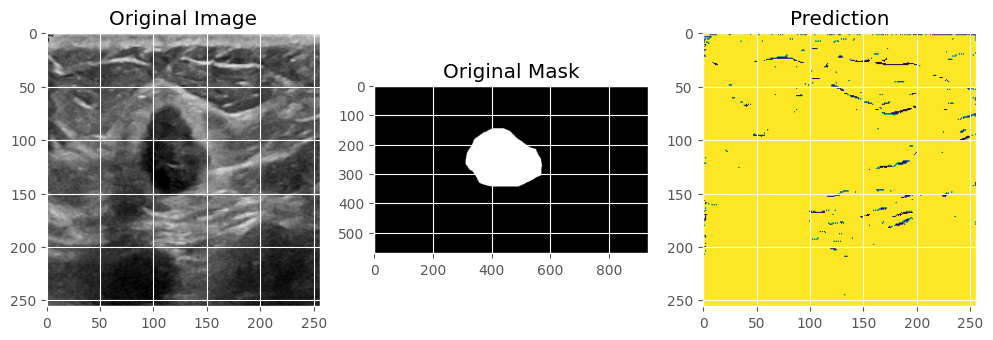

1/1 [==============================] - 1s 871ms/step


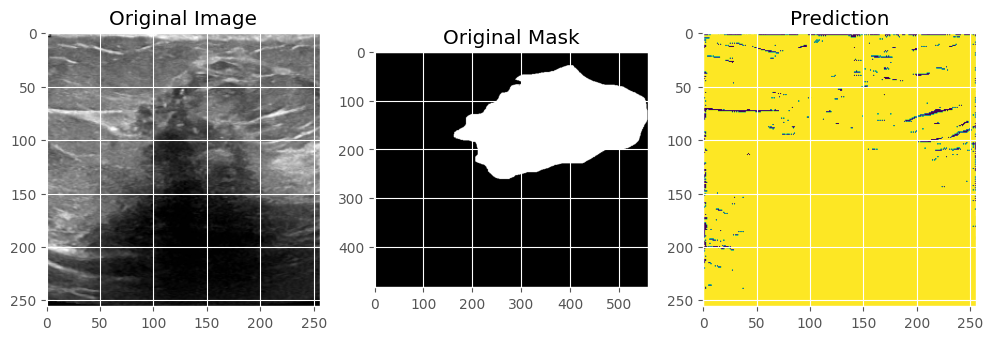

In [54]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (in_height, in_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()